**Aspectos prácticos de las redes neuronales**

En esta segunda parte, vamos a continuar desarrollando el problema de Fashion MNIST, con el objetivo de entender los aspectos prácticos del entrenamiento de redes neuronales que hemos visto en clase.

El código utilizado para contestar tiene que quedar claramente reflejado en el Notebook. Puedes crear nuevas cells si así lo deseas para estructurar tu código y sus salidas. A la hora de entregar el notebook, **asegúrate de que los resultados de ejecutar tu código han quedado guardados**. 

In [45]:
# Puedes añadir todos los imports adicionales que necesites aquí
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.initializers import Zeros, RandomNormal, GlorotUniform
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

#### Obtención de los datos y pre-processing

In [14]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

## Consideraciones iniciales

### Train-validation-test split

En todos los modelos que entrenemos, vamos a partir los datos de training (x_train) en dos sets: training y validación. De este modo, al final tendremos tres datasets distintos: training, validation, y test. Esta es una estrategia común en el aprendizaje automático, en la que los datos de test (o held-out data) se 
"esconden" hasta el final. Los datos de validación se utilizan para estimar cómo de bien están funcionando nuestros modelos y para observar si estamos cayendo en overfitting. Esto nos permite cambiar hiperparámetros y probar distintas arquitecturas **sabiendo que no estamos utilizando información del test set para "optimizar" los resultados en éste** (si eligiéramos nuestro mejor modelo en base a los resultados de test, estaríamos "haciendo trampas", ya que se ha utilizado la información contenida en éste para elegir el modelo y las métricas reportadas serían optimistas).

Para utilizar un split training-validation data durante el entrenamiento, podemos partir nosotros mismos los datos o dejar que Keras lo haga. Podéis ver cómo hacer estas particiones en la documentación de *fit*.

**Requisito: En todos los entrenamientos de esta práctica, se requiere utilizar el 20% de los datos en x_train como  conjunto de datos de validación**

### Un error común con modelos de Keras

En esta práctica entrenaremos varios modelos para comparar resultados. Un error común en Keras es no instanciar un nuevo modelo cada vez que hacemos un nuevo entrenamiento. Al hacer

*model = Sequential()*

*model.add(lo que sea)  # Definición del modelo*

*model.fit()*

si queremos entrenar un nuevo modelo o el mismo modelo otra vez, es necesario volver a inicializar el modelo con model = Sequential(). Si olvidamos este paso y volvemos a hacer fit(), el modelo seguirá entrenando por donde se quedó en el último fit().

### Análisis de resultados 

A la hora de escribir las respuestas y los análisis pedidos, es importante presentar las conclusiones de manera adecuada a partir de lo visto en nuestros experimentos. Los Jupyter Notebook son una herramienta imprescindible para *data scientists* e ingenieros de Machine Learning para presentar los resultados, incluyendo soporte para incluir gráficas y elementos visuales. Podéis explicar vuestras observaciones del modo que consideréis adecuado, si bien recomendamos la utilización de gráficas para evaluar los entrenamientos y comparar resultados.

Como ayuda, las siguientes funciones pueden resultar interesantes a la hora de evaluar resultados. Todas ellas utilizan el objeto *history* que podéis obtener como salida del método *fit()* de Keras:

history = model.fit(x_train, y_train, ...)

Por supuesto, podéis modificarlas y utilizarlas como prefiráis para crear vuestros propios informes.

In [15]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()
    
# Nota: podéis cambiar los números aquí presentes y ejecutar esta línea si queréis cambiar el tamaño
# de las gráficas
# matplotlib.rcParams['figure.figsize'] = [8, 8]


## 1. Unidades de activación

En este ejercicio, vamos a evaluar la importancia de utilizar las unidades de activación adecuadas. Como hemos visto en clase, funciones de activación como sigmoid han dejado de utilizarse en favor de otras unidades como ReLU.

**Ejercicio 1 ****: Partiendo de una red sencilla como la desarrollada en el Trabajo 1, escribir un breve análisis comparando la utilización de unidades sigmoid y ReLU (por ejemplo, se pueden comentar aspectos como velocidad de convergencia, métricas obtenidas...). Explicar por qué pueden darse estas diferencias. Opcionalmente, comparar con otras activaciones disponibles en Keras.



In [16]:
def create_model(activation_function):
    model = Sequential([
        Flatten(input_shape=(28, 28)),  # Transforma la entrada en un vector
        Dense(128, activation=activation_function),  # Capa densa con la función de activación especificada
        Dense(10, activation='softmax')  # Capa de salida para clasificación de 10 clases
    ])
    model.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


### Sigmoid

In [17]:
model_sigmoid = create_model('sigmoid')
history_sigmoid = model_sigmoid.fit(x_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.5664 - accuracy: 0.8075 - val_loss: 0.4475 - val_accuracy: 0.8421
Epoch 2/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4046 - accuracy: 0.8557 - val_loss: 0.4003 - val_accuracy: 0.8528
Epoch 3/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3669 - accuracy: 0.8677 - val_loss: 0.3731 - val_accuracy: 0.8625
Epoch 4/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3421 - accuracy: 0.8768 - val_loss: 0.3439 - val_accuracy: 0.8748
Epoch 5/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3225 - accuracy: 0.8819 - val_loss: 0.3441 - val_accuracy: 0.8748
Epoch 6/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3065 - accuracy: 0.8875 - val_loss: 0.3371 - val_accuracy: 0.8784
Epoch 7/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2929 - accuracy: 0.8923 - val_loss: 0.3295 - val_accuracy:

#### Relu

In [18]:
model_relu = create_model('relu')
history_relu = model_relu.fit(x_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5218 - accuracy: 0.8160 - val_loss: 0.4157 - val_accuracy: 0.8515
Epoch 2/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3846 - accuracy: 0.8612 - val_loss: 0.3668 - val_accuracy: 0.8666
Epoch 3/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3464 - accuracy: 0.8749 - val_loss: 0.3535 - val_accuracy: 0.8752
Epoch 4/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3193 - accuracy: 0.8833 - val_loss: 0.3396 - val_accuracy: 0.8777
Epoch 5/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3008 - accuracy: 0.8895 - val_loss: 0.3280 - val_accuracy: 0.8813
Epoch 6/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2866 - accuracy: 0.8940 - val_loss: 0.3275 - val_accuracy: 0.8811
Epoch 7/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2721 - accuracy: 0.8980 - val_loss: 0.3521 - val_accuracy:

#### Comparar los resultados

C:\Users\Adri\AppData\Local\Temp\ipykernel_15248\3436684436.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(history1.history['val_loss'], 'r--', color="green")
C:\Users\Adri\AppData\Local\Temp\ipykernel_15248\3436684436.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(history2.history['val_loss'], 'r--', color="blue")


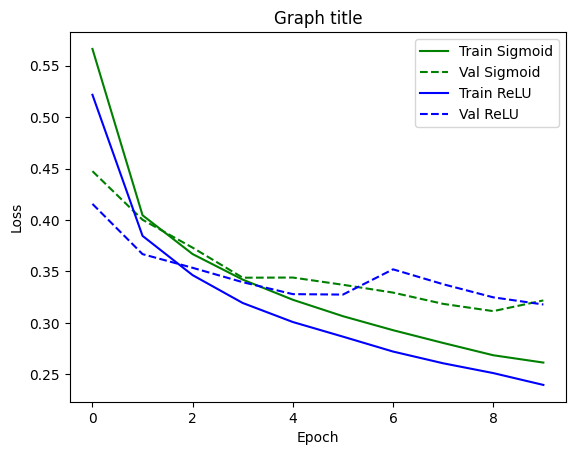

C:\Users\Adri\AppData\Local\Temp\ipykernel_15248\3436684436.py:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(history1.history['val_accuracy'], 'r--', color="green")
C:\Users\Adri\AppData\Local\Temp\ipykernel_15248\3436684436.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(history2.history['val_accuracy'], 'r--', color="blue")


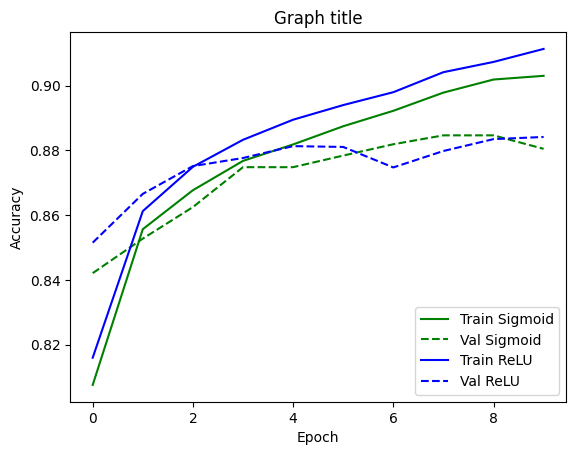

In [19]:
plot_compare_losses(history_sigmoid, history_relu, name1="Sigmoid", name2="ReLU")
plot_compare_accs(history_sigmoid, history_relu, name1="Sigmoid", name2="ReLU")

## 2. Inicialización de parámetros

En este ejercicio, vamos a evaluar la importancia de una correcta inicialización de parámetros en una red neuronal.

**Ejercicio 2 ***: Partiendo de una red similar a la del ejercicio anterior (usando ya ReLUs), comentar las diferencias que se aprecian en el entrenamiento al utilizar distintas estrategias de inicialización de parámetros. Para ello, inicializar todas las capas con las siguientes estrategias, disponibles en Keras, y analizar sus diferencias:

* Inicialización con ceros.
* Inicialización con una variable aleatoria normal.
* Inicialización con los valores por defecto de Keras para una capa Dense (estrategia *glorot uniform*)

In [26]:
def create_model_with_initialization(initializer):
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu', kernel_initializer=initializer),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

### Inizialización con ceros

In [28]:
model_zeros = create_model_with_initialization(Zeros())
history_zeros = model_zeros.fit(x_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 4s 2ms/step - loss: 2.3028 - accuracy: 0.0985 - val_loss: 2.3027 - val_accuracy: 0.0995
Epoch 2/10
1500/1500 [==============================] - 3s 2ms/step - loss: 2.3028 - accuracy: 0.0993 - val_loss: 2.3028 - val_accuracy: 0.0957
Epoch 3/10
1500/1500 [==============================] - 3s 2ms/step - loss: 2.3028 - accuracy: 0.0970 - val_loss: 2.3029 - val_accuracy: 0.0983
Epoch 4/10
1500/1500 [==============================] - 3s 2ms/step - loss: 2.3028 - accuracy: 0.1006 - val_loss: 2.3027 - val_accuracy: 0.1005
Epoch 5/10
1500/1500 [==============================] - 3s 2ms/step - loss: 2.3027 - accuracy: 0.1001 - val_loss: 2.3028 - val_accuracy: 0.0995
Epoch 6/10
1500/1500 [==============================] - 3s 2ms/step - loss: 2.3028 - accuracy: 0.0997 - val_loss: 2.3027 - val_accuracy: 0.0995
Epoch 7/10
1500/1500 [==============================] - 3s 2ms/step - loss: 2.3028 - accuracy: 0.0993 - val_loss: 2.3027 - val_accuracy:

### Inicialización con una variable aleatoria normal

In [29]:
model_random_normal = create_model_with_initialization(RandomNormal())
history_random_normal = model_random_normal.fit(x_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.5117 - accuracy: 0.8191 - val_loss: 0.4219 - val_accuracy: 0.8508
Epoch 2/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3852 - accuracy: 0.8609 - val_loss: 0.3787 - val_accuracy: 0.8636
Epoch 3/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3435 - accuracy: 0.8734 - val_loss: 0.3662 - val_accuracy: 0.8684
Epoch 4/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3191 - accuracy: 0.8816 - val_loss: 0.3815 - val_accuracy: 0.8593
Epoch 5/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3014 - accuracy: 0.8898 - val_loss: 0.3313 - val_accuracy: 0.8804
Epoch 6/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.2829 - accuracy: 0.8960 - val_loss: 0.3313 - val_accuracy: 0.8786
Epoch 7/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2713 - accuracy: 0.8992 - val_loss: 0.3461 - val_accuracy:

### Inicialización glorot uniform

In [30]:
model_glorot_uniform = create_model_with_initialization(GlorotUniform())
history_glorot_uniform = model_glorot_uniform.fit(x_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.5211 - accuracy: 0.8183 - val_loss: 0.4256 - val_accuracy: 0.8503
Epoch 2/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3822 - accuracy: 0.8627 - val_loss: 0.3653 - val_accuracy: 0.8710
Epoch 3/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3403 - accuracy: 0.8766 - val_loss: 0.3543 - val_accuracy: 0.8731
Epoch 4/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3187 - accuracy: 0.8827 - val_loss: 0.3457 - val_accuracy: 0.8794
Epoch 5/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2990 - accuracy: 0.8896 - val_loss: 0.3503 - val_accuracy: 0.8765
Epoch 6/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2836 - accuracy: 0.8954 - val_loss: 0.3352 - val_accuracy: 0.8817
Epoch 7/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2721 - accuracy: 0.8996 - val_loss: 0.3093 - val_accuracy:

### Comparar los modelos

C:\Users\Adri\AppData\Local\Temp\ipykernel_15248\3436684436.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(history1.history['val_loss'], 'r--', color="green")
C:\Users\Adri\AppData\Local\Temp\ipykernel_15248\3436684436.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(history2.history['val_loss'], 'r--', color="blue")


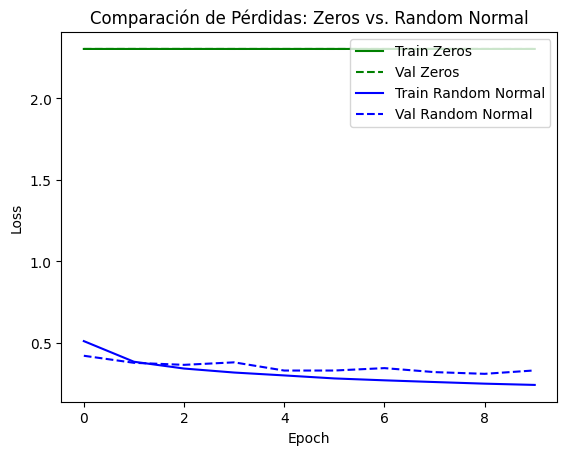

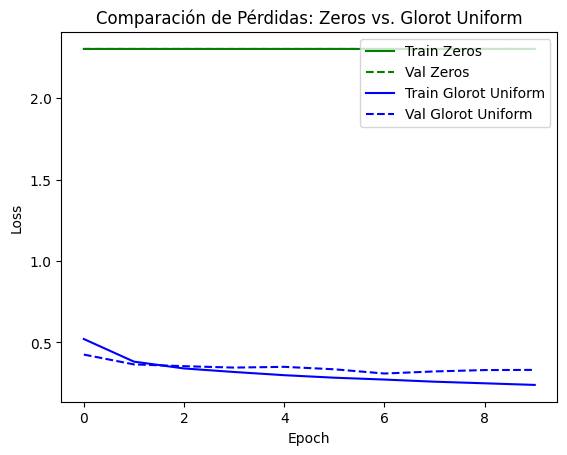

C:\Users\Adri\AppData\Local\Temp\ipykernel_15248\3436684436.py:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(history1.history['val_accuracy'], 'r--', color="green")
C:\Users\Adri\AppData\Local\Temp\ipykernel_15248\3436684436.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(history2.history['val_accuracy'], 'r--', color="blue")


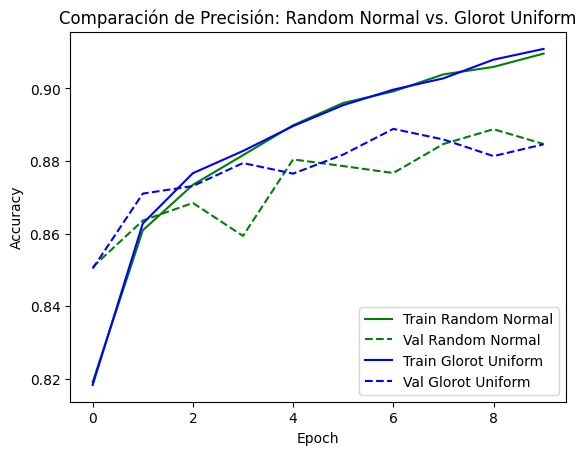

In [31]:
plot_compare_losses(history_zeros, history_random_normal, name1="Zeros", name2="Random Normal", title="Comparación de Pérdidas: Zeros vs. Random Normal")
plot_compare_losses(history_zeros, history_glorot_uniform, name1="Zeros", name2="Glorot Uniform", title="Comparación de Pérdidas: Zeros vs. Glorot Uniform")
plot_compare_accs(history_random_normal, history_glorot_uniform, name1="Random Normal", name2="Glorot Uniform", title="Comparación de Precisión: Random Normal vs. Glorot Uniform")

## 3. Optimizadores

**Ejercicio 3 ****: Partiendo de una red similar a la del ejercicio anterior (utilizando la mejor estrategia de inicialización observada), comparar y analizar las diferencias que se observan  al entrenar con varios de los optimizadores vistos en clase, incluyendo SGD como optimizador básico (se puede explorar el espacio de hiperparámetros de cada optimizador, aunque para optimizadores más avanzados del estilo de adam y RMSprop es buena idea dejar los valores por defecto provistos por Keras).

In [35]:
def create_model_with_optimizer(optimizer, initializer):
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu', kernel_initializer=initializer),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

### Utilizar el mejor inizializador

In [36]:
initializer = GlorotUniform()

### Definir varios optimizadores para comparar

In [37]:
optimizers = {
    'SGD': SGD(),
    'Adam': Adam(),
    'RMSprop': RMSprop()
}

### Entrenamiento

In [38]:
histories = {}
for name, opt in optimizers.items():
    model = create_model_with_optimizer(opt, initializer)
    print(f"Entrenando con el optimizador: {name}")
    history = model.fit(x_train, y_train, epochs=10, validation_split=0.2, verbose=0)
    histories[name] = history
    print(f"Entrenamiento con {name} completado.")

Entrenando con el optimizador: SGD
Entrenamiento con SGD completado.
Entrenando con el optimizador: Adam


C:\Users\Adri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Entrenamiento con Adam completado.
Entrenando con el optimizador: RMSprop
Entrenamiento con RMSprop completado.


### Mostrar resultados

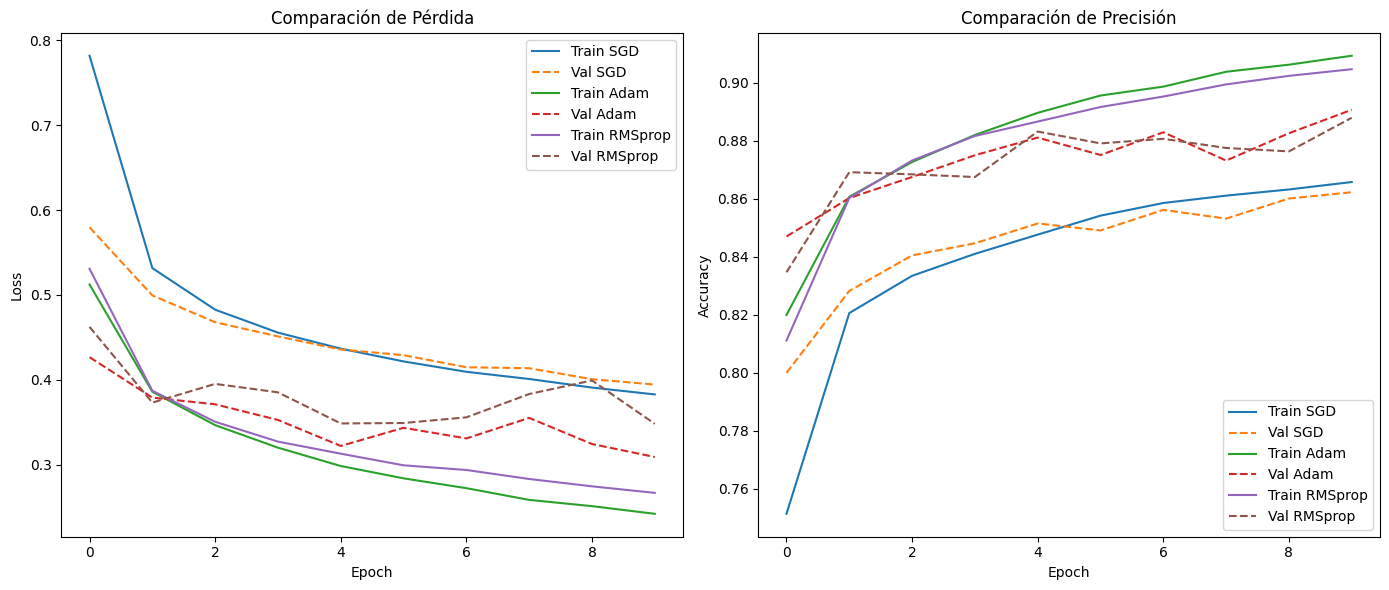

In [44]:
plt.figure(figsize=(14, 6))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
for name, history in histories.items():
    plt.plot(history.history['loss'], label=f'Train {name}')
    plt.plot(history.history['val_loss'], linestyle='--', label=f'Val {name}')
plt.title('Comparación de Pérdida')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Gráfico de precisión
plt.subplot(1, 2, 2)
for name, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'Train {name}')
    plt.plot(history.history['val_accuracy'], linestyle='--', label=f'Val {name}')
plt.title('Comparación de Precisión')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 4. Regularización y red final **

**Ejercicio 4.1**: Entrenar una red final que sea capaz de obtener una accuracy en el validation set cercana al 90%. Para ello, combinar todo lo aprendido anteriormente y utilizar técnicas de regularización para evitar overfitting. Algunos de los elementos que pueden tenerse en cuenta son los siguientes.

* Número de capas y neuronas por capa
* Optimizadores y sus parámetros
* Batch size
* Unidades de activación
* Uso de capas dropout, regularización L2, regularización L1...
* Early stopping (se puede aplicar como un callback de Keras, o se puede ver un poco "a ojo" cuándo el modelo empieza a caer en overfitting y seleccionar el número de epochs necesarias)
* Batch normalization

Si los modelos entrenados anteriormente ya se acercaban al valor requerido de accuracy, probar distintas estrategias igualmente y comentar los resultados.

Explicar brevemente la estrategia seguida y los modelos probados para obtener el modelo final, que debe verse entrenado en este Notebook. No es necesario guardar el entrenamiento de todos los modelos que se han probado, es suficiente con explicar cómo se ha llegado al modelo final.

### Creación del modelo

In [52]:
model_final = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu', kernel_initializer=GlorotUniform(), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

### Compilar modelo

In [53]:
model_final.compile(optimizer='nadam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

### Early Stopping

In [54]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

### Entrenamiento

In [55]:
history_final = model_final.fit(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
1500/1500 [==============================] - 6s 3ms/step - loss: 0.8122 - accuracy: 0.7730 - val_loss: 0.6210 - val_accuracy: 0.8196
Epoch 2/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6557 - accuracy: 0.8080 - val_loss: 0.5495 - val_accuracy: 0.8368
Epoch 3/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6183 - accuracy: 0.8126 - val_loss: 0.5530 - val_accuracy: 0.8202
Epoch 4/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6091 - accuracy: 0.8159 - val_loss: 0.5764 - val_accuracy: 0.8056
Epoch 5/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6036 - accuracy: 0.8148 - val_loss: 0.5195 - val_accuracy: 0.8409
Epoch 6/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5938 - accuracy: 0.8133 - val_loss: 0.5028 - val_accuracy: 0.8452
Epoch 7/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5990 - accuracy: 0.8164 - val_loss: 0.5448 - val_ac

En este nuevo modelo he incorporado los siguientes cambios:

- Regularización L2 en la primera capa densa para reducir el overfitting.
- Batch Normalization para estabilizar la aprendizaje.
- Dropout para prevenir la dependencia excesiva en neuronas específicas.
- Early Stopping para detener el entrenamiento cuando el modelo deja de mejorar en el conjunto de validación.

### Evaluación del modelo en datos de test

Una vez elegido el que creemos que es nuestro mejor modelo a partir de la estimación que hemos visto en los datos de validación, es hora de utilizar los datos de test para ver cómo se comporta nuestro modelo ante nuevos datos. Si hemos hecho bien las cosas, este número debería ser parecido al valor de nuestra estimación vista en los datos de validación.

**Pregunta 4.2**. Utilizando nuestro mejor modelo, obtener la accuracy resultante en el dataset de test. Comentar este resultado.

In [56]:
val_loss, val_acc = model_final.evaluate(x_test, y_test)
print(f"Validation accuracy: {val_acc*100:.2f}%")

313/313 [==============================] - 1s 1ms/step - loss: 0.5420 - accuracy: 0.8344
Validation accuracy: 83.44%


In [57]:
model_enhanced = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(256, activation='relu', kernel_initializer=GlorotUniform(), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_initializer=GlorotUniform(), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_initializer=GlorotUniform(), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model_enhanced.compile(optimizer='nadam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history_enhanced = model_enhanced.fit(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

# Evaluar el modelo
val_loss, val_acc = model_enhanced.evaluate(x_test, y_test)
print(f"Enhanced model validation accuracy: {val_acc*100:.2f}%")


Epoch 1/100
1500/1500 [==============================] - 10s 4ms/step - loss: 1.4173 - accuracy: 0.6853 - val_loss: 0.9190 - val_accuracy: 0.8052
Epoch 2/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.9914 - accuracy: 0.7669 - val_loss: 0.7503 - val_accuracy: 0.8232
Epoch 3/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.8523 - accuracy: 0.7765 - val_loss: 0.6116 - val_accuracy: 0.8407
Epoch 4/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.7933 - accuracy: 0.7808 - val_loss: 0.6466 - val_accuracy: 0.8224
Epoch 5/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.8038 - accuracy: 0.7751 - val_loss: 0.5993 - val_accuracy: 0.8352
Epoch 6/100
1500/1500 [==============================] - 7s 4ms/step - loss: 0.7544 - accuracy: 0.7905 - val_loss: 0.6174 - val_accuracy: 0.8217
Epoch 7/100
1500/1500 [==============================] - 7s 4ms/step - loss: 0.7432 - accuracy: 0.7921 - val_loss: 0.6319 - val_a

KeyboardInterrupt: 